### Analysis on Tesla data

The purpose of this Notebook is to determine the main topics 
of the news articles for Tesla and train Random Forest and 
Logistic Regression to predict next day movement of volatility

In [54]:
# Import libraries
import pandas as pd
import numpy as np
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re

# Granger's casuality test library
from statsmodels.tsa.stattools import grangercausalitytests

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


from statsmodels.tsa.api import VAR


# Import VADER for sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from wordcloud import WordCloud
from gensim.models import LdaModel

import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/luca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/luca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luca/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
news_df = pd.read_csv('../Data/Output/obj2_ESG_news_clean.csv')

### Latent Dirichlet Allocation (LDA) fot topics distribution

In [56]:
# Let's extrapolate the pre-processed news articles for Tesla only
Tesla_news_df = news_df[news_df['company'] == 'Tesla'].reset_index(drop=True)
Tesla_news_df.head()

,story,date,company,ticker
0,new york ny accesswire july bronstein gewirtz ...,2024-07-29,Tesla,esg
1,new york new yorknewsfile corp july pomerantz ...,2024-07-28,Tesla,esg
2,new york ny accesswire july bronstein gewirtz ...,2024-07-28,Tesla,esg
3,tesla inc tsla investigation bronstein gewirtz...,2024-07-26,Tesla,esg
4,tesla inc tslaqtlf shareholder alert pomerantz...,2024-07-26,Tesla,esg


In [57]:
Tesla_news_df.describe()

,story,date,company,ticker
count,198,198,198,198
unique,140,49,1,5
top,new york ny accesswire july bronstein gewirtz ...,2024-07-26,Tesla,esg
freq,8,23,198,62


In [58]:
Tesla_news_df = Tesla_news_df[['story','date','company']]
Tesla_news_df.head()

,story,date,company
0,new york ny accesswire july bronstein gewirtz ...,2024-07-29,Tesla
1,new york new yorknewsfile corp july pomerantz ...,2024-07-28,Tesla
2,new york ny accesswire july bronstein gewirtz ...,2024-07-28,Tesla
3,tesla inc tsla investigation bronstein gewirtz...,2024-07-26,Tesla
4,tesla inc tslaqtlf shareholder alert pomerantz...,2024-07-26,Tesla


In [59]:
Tesla_news_df.describe()

,story,date,company
count,198,198,198
unique,140,49,1
top,new york ny accesswire july bronstein gewirtz ...,2024-07-26,Tesla
freq,8,23,198


### Convert Preprocessed Data into Document-Term Matrix:

In [60]:
# Let's use the CountVectorizer from scikit-learn to transform 
# the preprocessed news articles into a document-term matrix.

news_list = Tesla_news_df['story'].tolist()

In [61]:
s = pd.Series(news_list)
s.describe()

count                                                   198
unique                                                  140
top       new york ny accesswire july bronstein gewirtz ...
freq                                                      8
dtype: object

In [62]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(news_list)

In [63]:
dtm

<198x7522 sparse matrix of type '<class 'numpy.int64'>'
	with 40341 stored elements in Compressed Sparse Row format>

### Train the LDA Model

In [64]:
# Let's use gensim to create an LDA model. 

# Tokenize each document in the news_list
tokenized_news_list = [word_tokenize(doc.lower()) for doc in news_list]

In [65]:
# Create a dictionary from the tokenized news
dictionary = corpora.Dictionary(tokenized_news_list)

In [66]:
# Convert the dictionary into a bag of words (BoW) corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_news_list]

In [67]:
# Let's create a function to calculate coherence score in order to 
# determine the best number of topics to train the LDA model 

def compute_coherence_values(dictionary, corpus, tokenized_news_list, start, limit, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Train LDA model
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       random_state=69,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        
        # Compute coherence score
        coherence_model = CoherenceModel(model=model, 
                                         texts=tokenized_news_list, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values

In [68]:
# Set the range for the number of topics to test
start = 2    
limit = 15   
step = 1     

In [69]:
# Get the optimal model based on coherence score
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokenized_news_list, start, limit, step)

In [70]:
# Get the best model with the highest coherence score
optimal_num_topics = start + coherence_values.index(max(coherence_values)) * step
best_model = model_list[coherence_values.index(max(coherence_values))]

In [71]:
# Print the best number of topics and the coherence score
print(f"Optimal number of topics: {optimal_num_topics}")
print(f"Coherence score: {max(coherence_values)}")

Optimal number of topics: 7
Coherence score: 0.5434013703298904


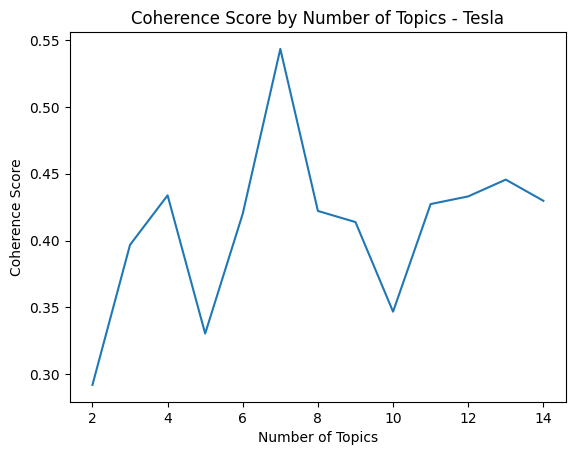

In [74]:
# Let's plot the coherence score 
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics - Tesla")
plt.show()

### Let's verify if the topics are coherent by leveraging the word clouds

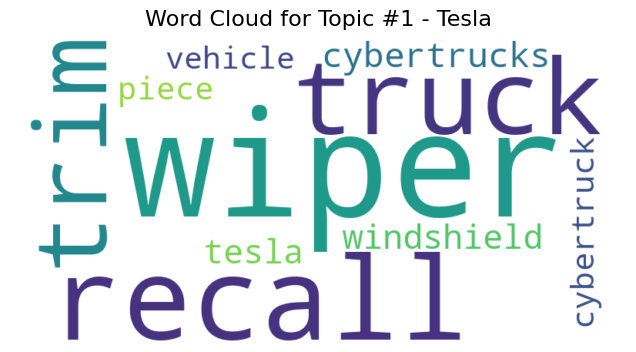

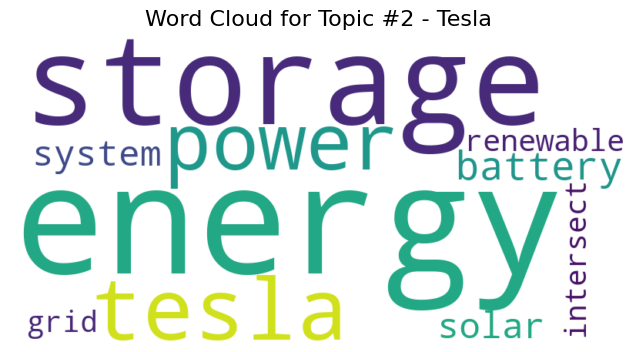

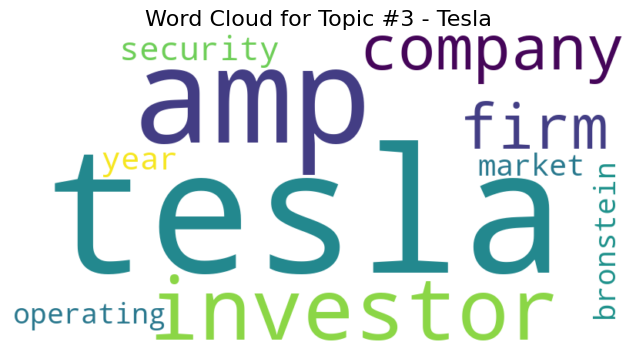

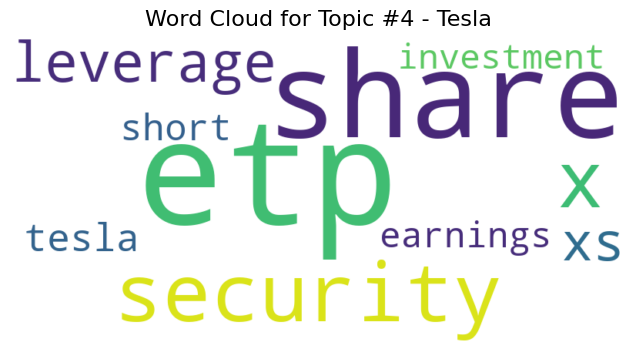

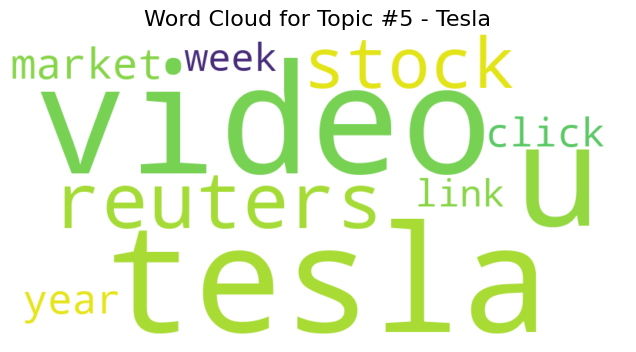

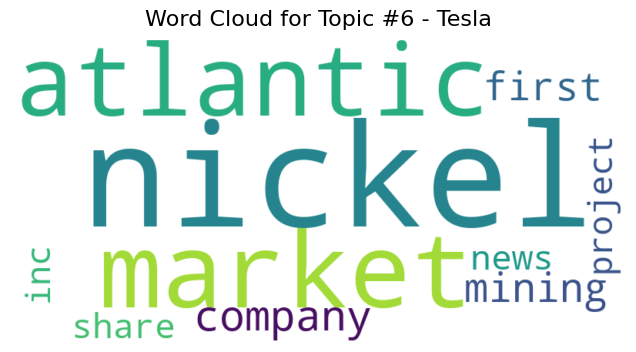

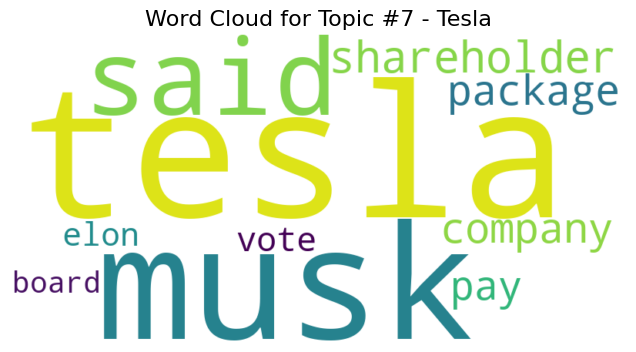

In [75]:
# Let's plot a word cloud for each topic
def plot_word_cloud(lda_model, num_topics, num_words=10):
    for topic_num in range(num_topics):
        # Get the words and their weights for each topic
        topic_words = lda_model.show_topic(topic_num, num_words)
        
        # Convert the topic words to a dictionary where keys are words and values are their importance (weights)
        word_dict = {word: weight for word, weight in topic_words}
        
        # Generate the word cloud for the topic
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
        
        # Plot the word cloud
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic #{topic_num + 1} - Tesla", fontsize=16)
        plt.show()

# Get the number of topics from the best model
num_topics = best_model.num_topics

# Plot word clouds for all topics
plot_word_cloud(best_model, num_topics)

In [20]:
# Function to get dominant topic for each document

def get_dominant_topic(lda_model, corpus):
    topic_list = []
    
    for doc_bow in corpus:
        # Get the topic distribution for the document
        topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        
        # Sort the topics by their probabilities and pick the most probable one
        dominant_topic = sorted(topics, key=lambda x: x[1], reverse=True)[0][0]
        
        # Append the dominant topic to the list
        topic_list.append(dominant_topic)
    
    return topic_list

# Assign the dominant topic for each document in the dataframe
Tesla_news_df['topic'] = get_dominant_topic(best_model, corpus)

print(Tesla_news_df.head())

                                               story        date company  \
0  new york ny accesswire july bronstein gewirtz ...  2024-07-29   Tesla   
1  new york new yorknewsfile corp july pomerantz ...  2024-07-28   Tesla   
2  new york ny accesswire july bronstein gewirtz ...  2024-07-28   Tesla   
3  tesla inc tsla investigation bronstein gewirtz...  2024-07-26   Tesla   
4  tesla inc tslaqtlf shareholder alert pomerantz...  2024-07-26   Tesla   

   topic  
0      2  
1      2  
2      2  
3      2  
4      2  


In [21]:
# Let's aggregate by date and average topic to avoid missing data 

avg_topics_df = Tesla_news_df.groupby('date')['topic'].mean().reset_index()

# Ensure the 'date' column is in datetime format
avg_topics_df['date'] = pd.to_datetime(avg_topics_df['date'])

# Remove weekends (Saturday and Sunday)
# Use the weekday() method where Monday is 0 and Sunday is 6
avg_topics_df= avg_topics_df[avg_topics_df['date'].dt.weekday < 5]

# Remove the row corresponding to bank holidays
# so the dimension of the df will match the list of stock trading days
avg_topics_df = avg_topics_df[avg_topics_df['date'] != pd.to_datetime('2024-05-06')]
avg_topics_df = avg_topics_df[avg_topics_df['date'] != pd.to_datetime('2024-05-27')]


print(avg_topics_df.head())

        date     topic
0 2024-05-08  6.000000
1 2024-05-10  4.666667
2 2024-05-14  6.000000
3 2024-05-17  5.200000
4 2024-05-20  2.000000


In [22]:
avg_topics_df.describe()

,date,topic
count,37,37.000000
mean,2024-06-21 00:38:55.135135232,3.904079
min,2024-05-08 00:00:00,0.000000
25%,2024-06-03 00:00:00,2.904762
50%,2024-06-25 00:00:00,4.000000
75%,2024-07-09 00:00:00,5.200000
max,2024-07-29 00:00:00,6.000000
std,NaN,1.673628


### Prepare the Target Variable (Market Returns):

#### Use the pre-existing sentiment scores and corresponding Tesla stock returns to create binary labels for market movement (e.g., "UP" or "DOWN") for the following day.

In [23]:
# Let's import merged_df from main

merged_df = pd.read_csv('../Data/Output/obj2_ESGnews_stock_merged.csv')
merged_df

,company,date,Sent_d,daily_return
0,Asda,2024-06-07,0.010250,-0.019094
1,Asda,2024-07-08,0.065600,-0.005153
2,Asda,2024-07-23,-0.045500,0.003829
3,Asda,2024-07-24,0.048000,-0.000708
4,Asda,2024-07-26,-0.049500,-0.003433
...,...,...,...,...
176,Toyota,2024-07-23,0.034458,0.003242
177,Toyota,2024-07-24,0.019665,-0.018041
178,Toyota,2024-07-25,0.025644,-0.009938
179,Toyota,2024-07-26,0.040455,-0.014081


In [24]:
# Let's isolate Tesla
Tesla_merged_df = merged_df[merged_df['company'] == 'Tesla'].reset_index(drop=True)
Tesla_merged_df.head()

,company,date,Sent_d,daily_return
0,Tesla,2024-05-08,0.001750,-0.017531
1,Tesla,2024-05-10,0.003834,-0.020562
2,Tesla,2024-05-14,-0.002999,0.032398
3,Tesla,2024-05-17,-0.013748,0.014874
4,Tesla,2024-05-20,0.092000,-0.014245


In [25]:
Tesla_merged_df.describe()

,Sent_d,daily_return
count,36.000000,36.000000
mean,0.026415,0.009626
std,0.033699,0.040573
min,-0.068400,-0.131643
25%,0.003313,-0.015066
50%,0.020730,0.004133
75%,0.044952,0.036867
max,0.101696,0.097102


In [26]:
# Let's create 'daily_return_list' as list of daily returns
daily_return_list = Tesla_merged_df['daily_return'].tolist()


In [27]:
daily_return_list

[-0.0175308719113163,
 -0.0205623505979954,
 0.0323975220490315,
 0.014873961412078,
 -0.0142450125934947,
 0.0644670695995464,
 -0.0360078465171916,
 -0.0139893851412601,
 -0.0039790452364939,
 -0.0101025212295827,
 -0.0025884883059126,
 -0.0210102527340662,
 -0.0181744006682036,
 0.0381135368018503,
 0.0287989660381547,
 -0.0247460474591023,
 0.0516190657101987,
 -0.0138600123629085,
 0.0257900921027615,
 0.0470221095224426,
 0.0053328042276029,
 0.002327347369766,
 0.0587798553702571,
 0.0971019769710506,
 0.0633730277193949,
 0.0206068628206312,
 0.0364509467364302,
 0.0153970048775675,
 -0.031919709848216,
 0.0029333193636387,
 0.050182728104264,
 -0.0206076906469125,
 -0.1316429492176659,
 0.0195311545001267,
 -0.0020452228467678,
 0.0544502713108703]

In [28]:
# Let's assume 'daily_return_list' is a list of binary 'daily_return'
labels = [1 if daily_return > 0 else 0 for daily_return in daily_return_list]

In [36]:
X = avg_topics_df[['topic']][2:] # Use double brackets to convert to a DataFrame
y = labels[1:]

In [37]:
print(len(X))  # Shape of the feature matrix
print(len(y))   # Length of the target vector (should be [n_samples])


35
35


### Training of the Classifier


#### Let's use Random Forest classifier to predict the next day's market movement based on the LDA topics.

In [38]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
 

In [39]:
# Let's train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
# Predict on test set
y_pred = clf.predict(X_test)


In [41]:
# Evaluate accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Accuracy: 0.2727272727272727


In [42]:
from sklearn.metrics import precision_score
# Evaluate precision
print(f'Precision: {precision_score(y_test, y_pred)}')

Precision: 0.3333333333333333


In [43]:


# Assuming you already have y_test and y_pred from your model predictions
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[2 2]
 [6 1]]


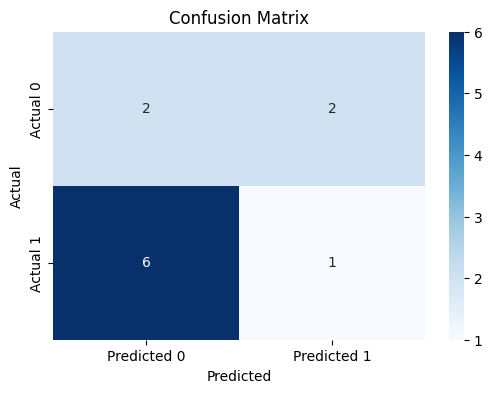

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Logistic Regression

In [47]:
X = avg_topics_df[['topic']][2:]  
y = pd.Series(labels[1:]) 

# Let's create lagged target variable for next day prediction
y = y.shift(-1)  # Shift y to make it represent the next day's values


In [48]:
# Let's remove the last row as y would be NaN after shifting
X = X[:-1]
y = y[:-1]

# Let's split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Let's train a Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


LogisticRegression()

In [49]:
# Let's make predictions
y_pred = log_reg.predict(X_test)

In [50]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [51]:
# Let's evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5454545454545454


In [52]:
# Let's evaluate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

Precision: 0.5454545454545454


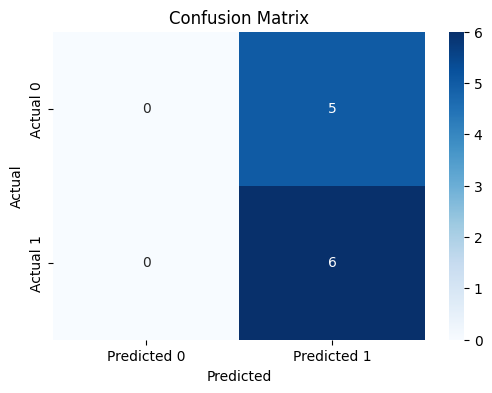

In [53]:
# Let's create confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## End of this part